In [1]:
import warnings
warnings.simplefilter('ignore')
 

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
rs = 2


In [2]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

##build window momentum features
for n in list(range(1,21)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n)#for trading with open
    
##build window momentum features (best features, but result is similar than w/ all 21)
#for n in list(range(1,6)):
#    name = 'ret' + str(n)
#    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open

#build date time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values
df_dummies_hour = pd.get_dummies(df["hour"], prefix='hour')
df_dummies_day = pd.get_dummies(df["day"], prefix='day')
df =df.join(df_dummies_hour)
df=df.join(df_dummies_day)
df.drop(["hour","day"], axis=1, inplace=True)


#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#df = np.log(df+1)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df.drop(cols_to_drop, axis=1, inplace=True)

#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]


In [3]:
#Exploratory Data Analysis
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def plot_corr(corr, size=5, title="Pearson correlation"):
    """Function plots a graphical correlation matrix dataframe 
    Input:
        df: pandas corr DataFrame from e.g. corr = df.corr(method='pierson')
        size: vertical and horizontal size of the plot
        title: title of the plot
    """
    fig, ax = plt.subplots(figsize=(size, size))
    #optionally, substitute the regular ax with an sns.heatmap (the regular ax has horrible colors)
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    square=True
    )
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    #plt.tight_layout() #can use instead of rotation='vertical'

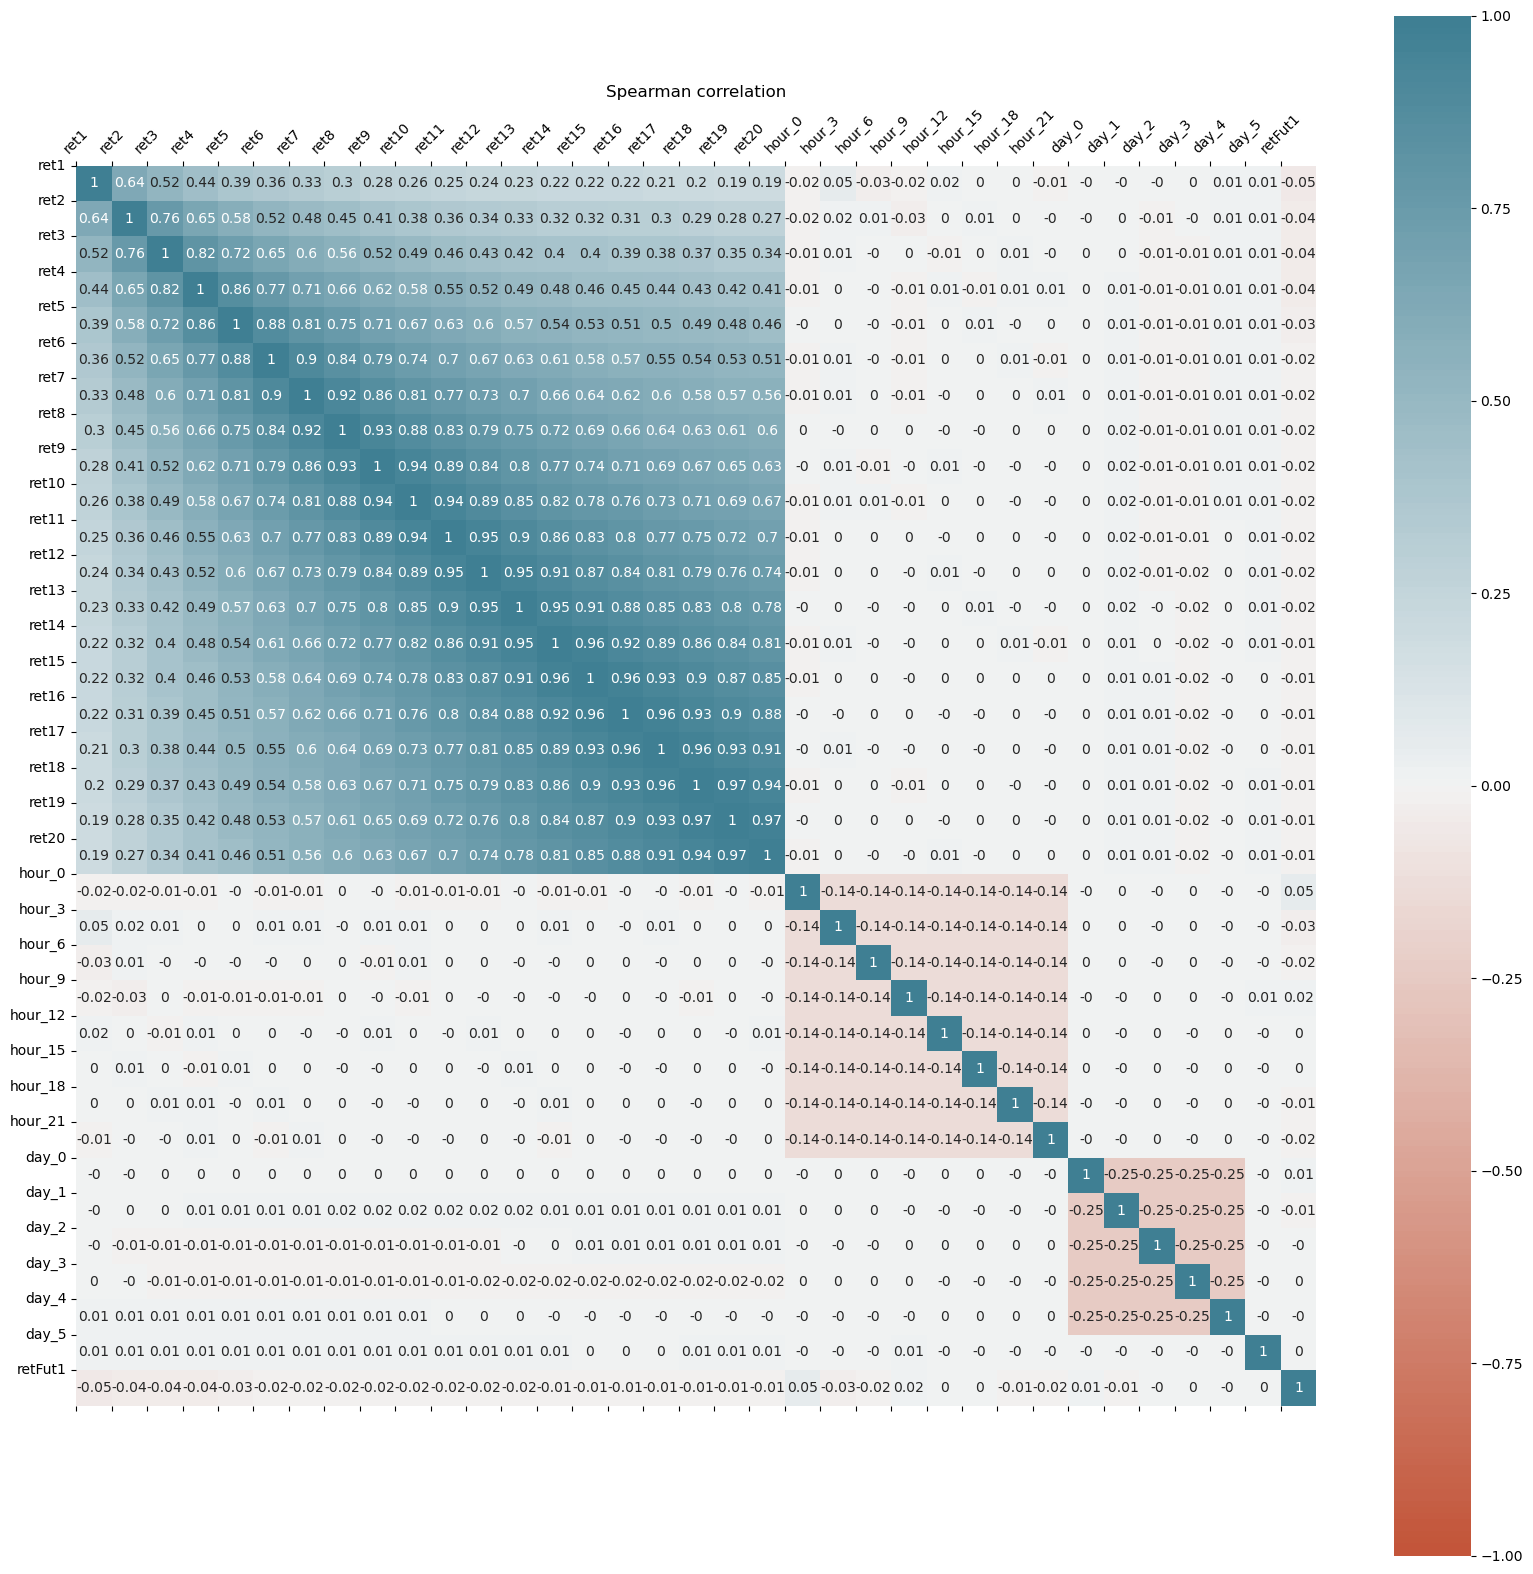

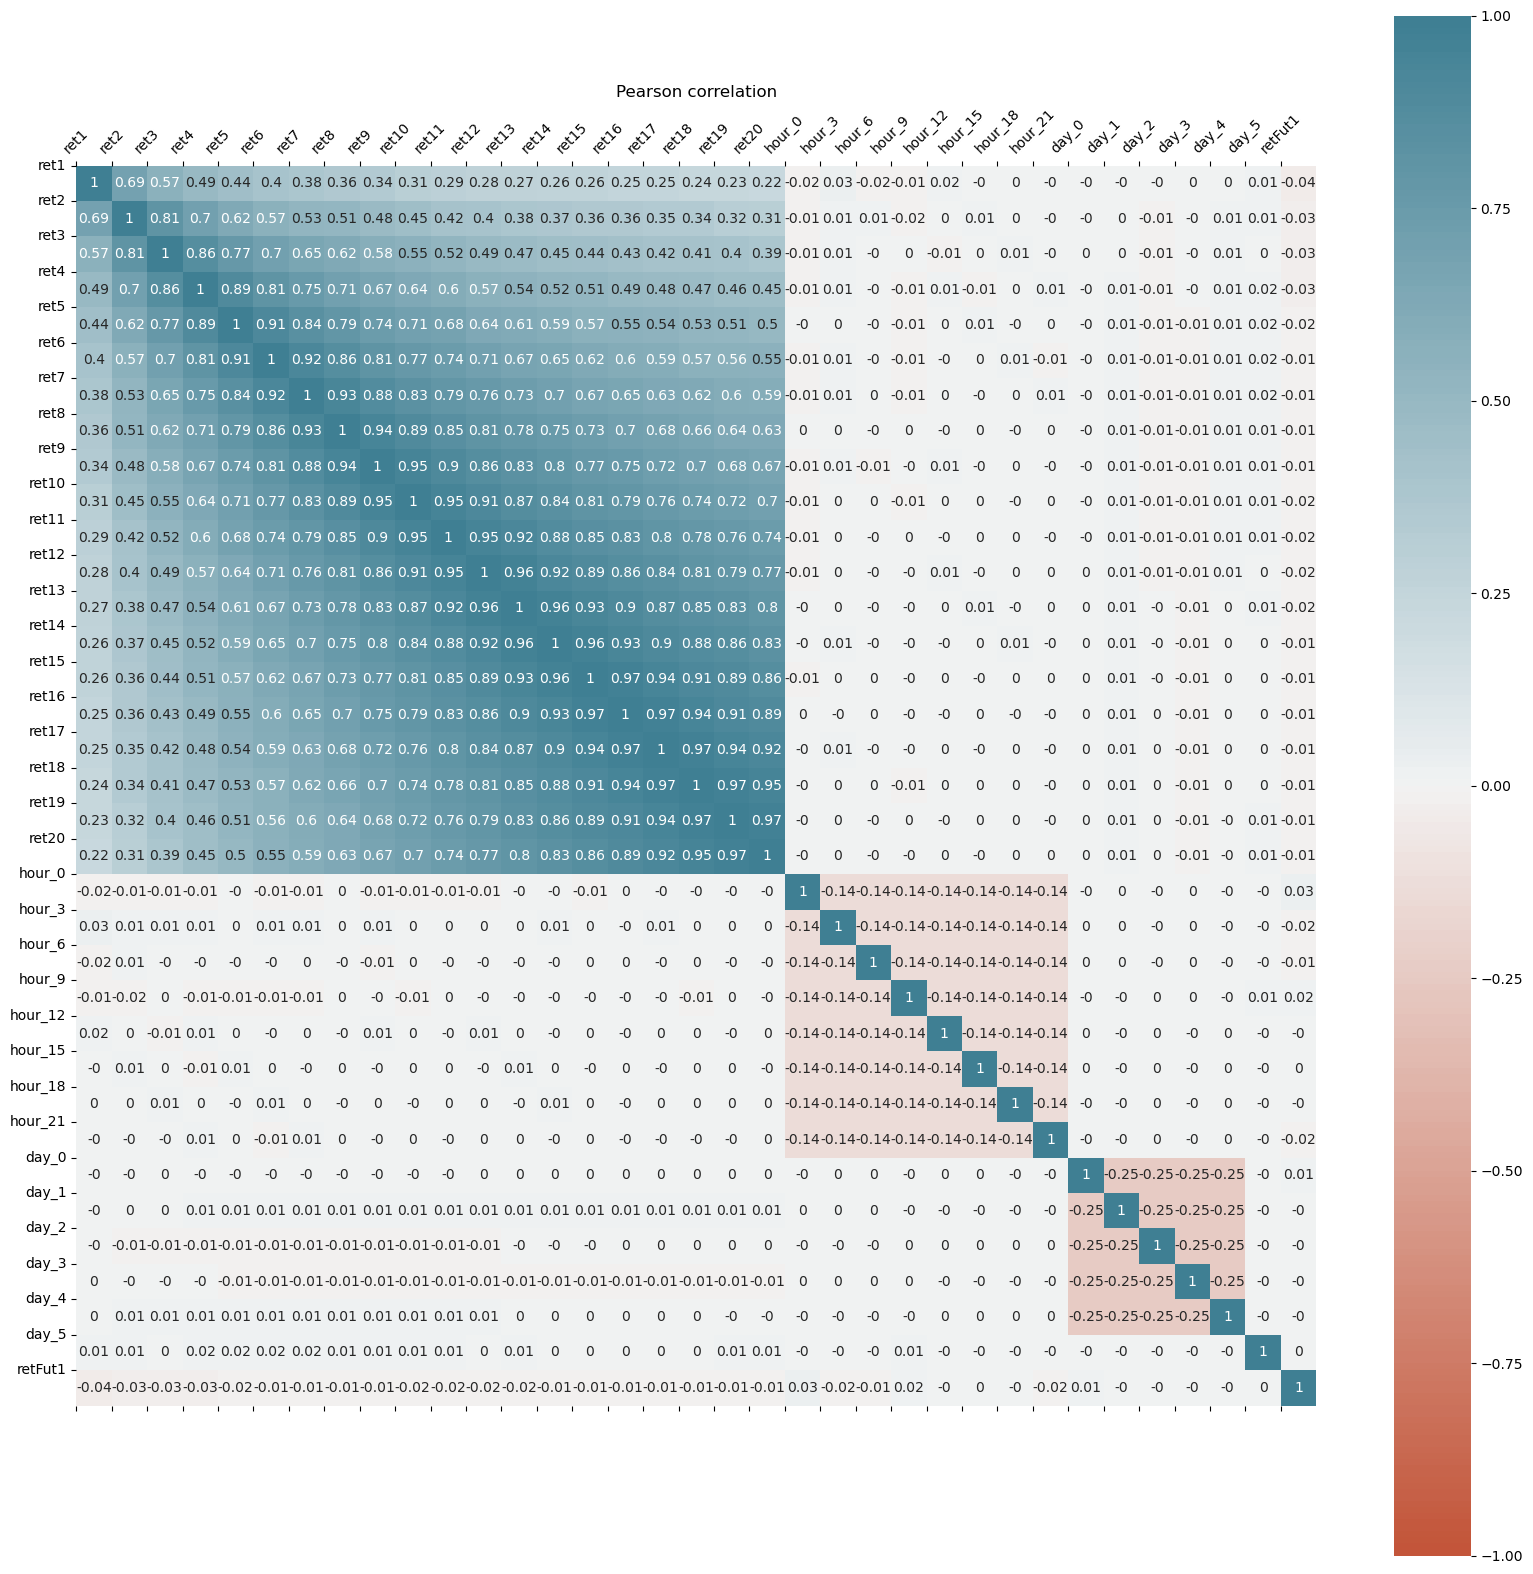

In [4]:
#get the non-categorical data  by excluding the uint8 dtype
#we do this because neither the spearman nor the pearson correlations can deal with categorical variables    
df_filtered = df.select_dtypes(exclude=['uint8'])

#Plot the matrix containing the pair-wise spearman coefficients
#ideally we want to pay special attention to the correlation between each period return and retFut1    
corr = df_filtered.corr(method='spearman').round(2)
plot_corr(corr, size=20, title="Spearman correlation")
#plt.show()
plt.savefig(r'Results\%s.png' %("Spearman Correlation Matrix"))

#Plot the matrix containing the pair-wise pearson coefficients
##ideally we want to pay special attention to the correlation between each period return and retFut1    
corr = df_filtered.corr(method='pearson').round(2)
plot_corr(corr, size=20, title="Pearson correlation")
#plt.show()
plt.savefig(r'Results\%s.png' %("Pearson Correlation Matrix"))

In [21]:
#You want to plot the significance of the correlations
#This is optional in our case because we have tons of data.
def calculate_pvalues(df, method='pearson'):
    # df = df.dropna()._get_numeric_data()
    df = df.dropna().select_dtypes(include=['number']).loc[:, df.dtypes != 'bool']

    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        if method=='pearson':
            for c in df.columns:
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
        else:
            for c in df.columns:
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)                
    return pvalues

#plot the significance values
print('pearson significance values')
print(calculate_pvalues(df_filtered, method='pearson'))
print('spearman significance values')
print(calculate_pvalues(df_filtered, method='spearman'))

pearson significance values
        ret1 ret2 ret3 ret4 ret5   ret6    ret7    ret8    ret9 ret10  ...  \
ret1     0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret10    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret11    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret12    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret13    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret14    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret15    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret16    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret17    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret18    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret19    0.0  0.0  0.0  0.0  0.0    0.0     0.0     0.0     0.0   0.0  ...   
ret2     0.0  0.0  0.0  0.0  0.0    

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer


In [7]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho


def sharpe(y_true, y_pred):
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * y_true
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_arr) / np.std(dailyRet_arr)
    return ratio

In [8]:
def profit_ratio(y_true, y_pred):
    positions = np.where(y_pred > 0, 1, -1)
    positions = np.nan_to_num(positions, nan=0.0)

    daily_ret = positions * y_true
    daily_ret = np.nan_to_num(daily_ret, nan=0.0)

    profit = np.sum(daily_ret[daily_ret > 0])
    loss = -np.sum(daily_ret[daily_ret < 0])
    if loss == 0:
        profit_ratio = np.inf 
    else:
        profit_ratio = profit / loss
    
    return profit_ratio

In [9]:
myscorer = make_scorer(information_coefficient, greater_is_better=True)

In [10]:
imputer = SimpleImputer(strategy="constant", fill_value=0)
#we turn off scaling because we should not scale dummies (and returns are already mostly scaled)
scaler = StandardScaler(with_mean=False, with_std=False)
ridge = Ridge(max_iter=1000) 

pipe = Pipeline([("imputer", imputer), ("scaler", scaler), ("ridge", ridge)])
a_rs = np.logspace(-7, 0, num=20, endpoint = True)

param_grid =  [{'ridge__alpha': a_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train.values, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

0.08415653583344032
0.09768268453329235
0.021484216989285196
0.10991596833560628
0.04692749791216141
0.1083737278884403
0.05449364910349822
0.10627014452538464
0.060246518478900606
0.11380882165417065
0.08586333479479773
0.09848390728546043
0.025209629954911526
0.11017610562519929
0.05037537200634074
0.10880063279507206
0.05658141858809517
0.10593765733657817
0.05127987061217396
0.11397073441030008
0.061664257091502354
0.08065591521602915
-0.006254174548280027
0.09437628588409702
0.04766081684919851
0.08657628429096076
0.020888194207786905
0.09067470849125947
0.07883220547757912
0.0839258468985555
0.0858505453005319
0.09848346795594572
0.0252134902851826
0.1101818193500037
0.0503648103812257
0.10880460773367458
0.056604166330356996
0.10593631200069614
0.05125550741554699
0.11397034483672665
0.08574892537330409
0.09841396021180784
0.02479493058172076
0.1101491914200828
0.04997377599895723
0.1087979583316813
0.0563860422573511
0.10595133490242022
0.05181917446470961
0.11405785273180709
0

In [11]:
print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_ridgereg.csv")

Best parameters : {'ridge__alpha': 1.2742749857031322e-06}
Best cross-validation score : 5.39


In [12]:
print(results.T)

                                                          0  \
mean_fit_time                                      0.065235   
std_fit_time                                       0.011797   
mean_score_time                                    0.021162   
std_score_time                                     0.013972   
param_ridge__alpha                                 0.002637   
params              {'ridge__alpha': 0.0026366508987303553}   
split0_test_score                                  0.084157   
split1_test_score                                  0.021484   
split2_test_score                                  0.046927   
split3_test_score                                  0.054494   
split4_test_score                                  0.060247   
mean_test_score                                    0.053462   
std_test_score                                     0.020271   
rank_test_score                                           8   
split0_train_score                                 0.09

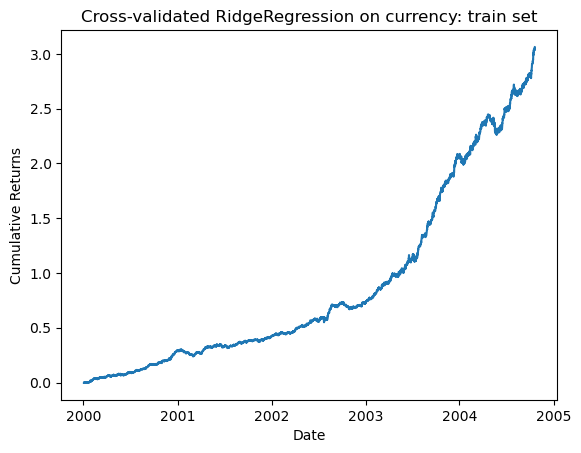

In [13]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train.values)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) #POSITIONS

dailyRet = pd.Series(positions).fillna(0).values * y_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


In [14]:
cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)

In [15]:
profits = np.sum(dailyRet[dailyRet > 0])
losses = -np.sum(dailyRet[dailyRet < 0])
p_ratio = profits / losses if losses != 0 else np.inf

In [16]:
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


In-sample: CAGR=0.0359179 Sharpe ratio=1.4004 Profit ratio=1.30626 maxDD=-0.054036 maxDDD=517 Calmar ratio=0.664702



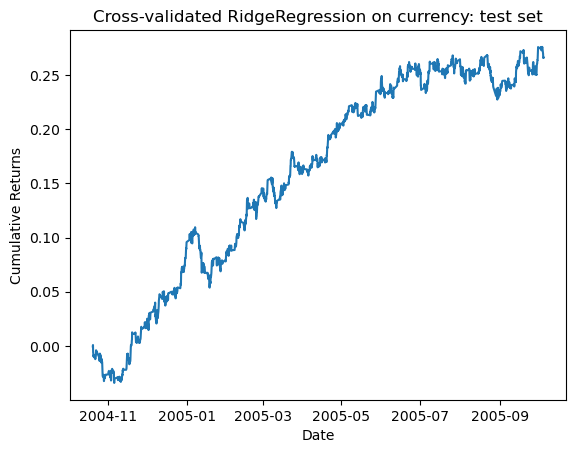

In [17]:
# Test set
# Make "predictions" on test set (out-of-sample)
#positions2 = np.where(best_model.predict(x_test.values)> 0,1,-1 ) 
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 ) #POSITIONS

dailyRet2 = pd.Series(positions2).fillna(0).values * y_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant


In [18]:
"""
INSTRUCTIONS
complete the profit_ratio (p_ratio) code below
make sure you use dailyRet2, not dailyRet

"""
cagr = (1 + cumret2[-1]) ** (252*8 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)

profits = np.sum(dailyRet2[dailyRet2 > 0])
losses = -np.sum(dailyRet2[dailyRet2 < 0])
p_ratio = profits / losses if losses != 0 else np.inf

print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


Out-of-sample: CAGR=0.268713 Sharpe ratio=0.933546 Profit ratio=1.181 maxDD=-0.050303 maxDDD=192 Calmar ratio=5.3419



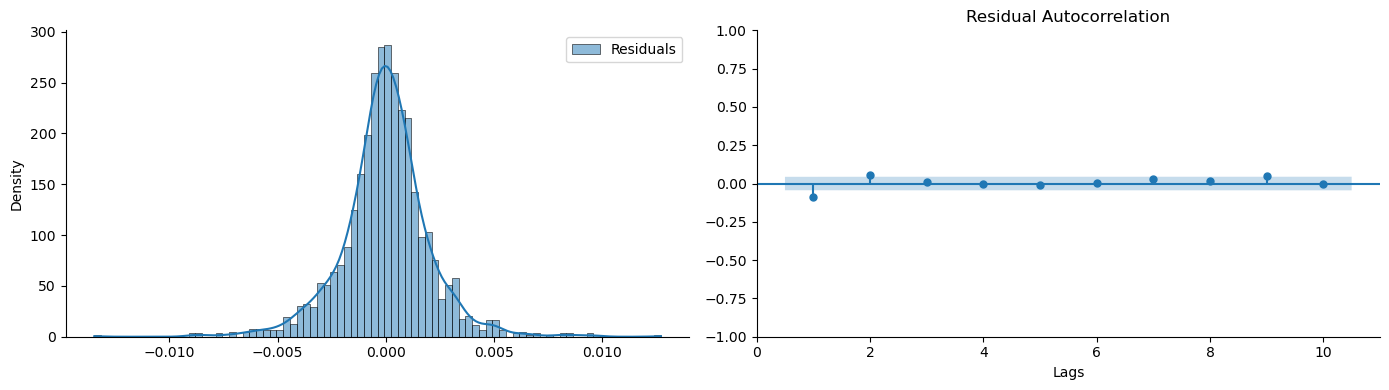

In [19]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test.values)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
# use histplot instead of distplot
sns.histplot(residuals, kde=True, stat='density', ax=axes[0], label='Residuals')

axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))

Ljung-Box test p-value 0.0013911920510847513


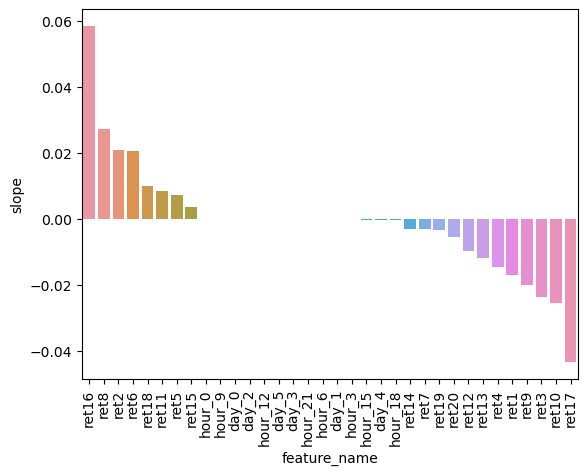

In [20]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0, 1])


#plot the coefficients
importance = pd.DataFrame(zip(best_model[2].coef_.ravel().tolist(), x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))